In [1]:
%matplotlib inline
# Load all necessary packages
import sys
import pandas  as pd
import numpy   as np
import seaborn as sns
sns.set()
sns.set_context("talk")
import matplotlib.pyplot as plt
# Import IBM's AI Fairness tooolbox
from aif360.datasets         import BinaryLabelDataset
from aif360.metrics          import BinaryLabelDatasetMetric
from aif360.metrics          import ClassificationMetric
from aif360.metrics.utils    import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.lfr import LFR
# Import scikit-learn core slibraries
from sklearn.metrics         import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split  
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import balanced_accuracy_score
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.metrics         import accuracy_score
from IPython.display         import Markdown, display
from typing                  import List, Union, Dict
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned Taiwan-Credit-Card-Cleaned-Marriage dataset
Taiwan_df = pd.read_csv('./input/Taiwan-Credit-Card-Cleaned-Marriage.csv')

In [3]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'MARRIAGE'
priv_grp            = 1  # Males 
unpriv_grp          = 0  # Females  
lab                 = 'DEFAULT'
fav_label           = 1 # Will not default next month
unfav_label         = 0 # Will default next month
privileged_groups   = [{protected_attr: priv_grp}]   # Males
unprivileged_groups = [{protected_attr: unpriv_grp}] # Females

In [4]:
# Create a Binary Label Dataset to use with AIF360 APIs
X = Taiwan_df.drop(lab,axis=1)
y = Taiwan_df[lab]

In [5]:
Taiwan_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)

In [6]:
# Create train and test datasets
Taiwan_train_bld, Taiwan_test_bld = Taiwan_bld.split([0.7], shuffle=True, seed=101)

In [7]:
scaler = MinMaxScaler(copy=False)
Taiwan_train_bld.features = scaler.fit_transform(Taiwan_train_bld.features)
Taiwan_test_bld.features  = scaler.fit_transform(Taiwan_test_bld.features)

In [8]:
Taiwan_train_df, d = Taiwan_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
Taiwan_test_df,  d = Taiwan_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [9]:
# First test whether it is possible to predict the Sensitive Variable from the whole original dataset
X_se_train = Taiwan_train_df.drop(protected_attr,axis=1)
y_se_train = Taiwan_train_df[protected_attr]
X_se_test  = Taiwan_test_df.drop(protected_attr,axis=1)
y_se_test  = Taiwan_test_df[protected_attr]

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.7065376392483402
Biased Random Forest       validation accuracy: 0.7332058062338247

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.6981152920619681
Biased Random Forest       balanced accuracy  : 0.7326415813005485


In [10]:
# Next get the number of labels from the modified training dataset
print('Training Before - DEFAULT value counts:')
print(Taiwan_train_df.DEFAULT.value_counts())
print('Training Before - MARRIAGE value counts:')
print(Taiwan_train_df.MARRIAGE.value_counts())

Training Before - DEFAULT value counts:
1.0    16100
0.0     4636
Name: DEFAULT, dtype: int64
Training Before - MARRIAGE value counts:
0.0    11237
1.0     9499
Name: MARRIAGE, dtype: int64


In [11]:
# Determine the baseline model accuracy for Logistic Regression and Random Forest Classifiers
X_train = Taiwan_train_df.drop(lab,axis=1)
y_train = Taiwan_train_df[lab]
X_test  = Taiwan_test_df.drop(lab,axis=1)
y_test  = Taiwan_test_df[lab]
BiasedLogModel = LogisticRegression(random_state=101)
BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
BiasedLogModel.fit(X_train, y_train) 
BiasedRfcModel.fit(X_train, y_train)
BiasedLogPredictions = BiasedLogModel.predict(X_test)
BiasedRfcPredictions = BiasedRfcModel.predict(X_test)
print(f"Biased Logistic regression validation accuracy: {BiasedLogModel.score(X_test, y_test)}")
print(f"Biased Random Forest       validation accuracy: {BiasedRfcModel.score(X_test, y_test)}")
print('')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test, BiasedLogPredictions)}")
print(f"Biased Random forest balanced accuracy        : {balanced_accuracy_score(y_test, BiasedRfcPredictions)}")

Biased Logistic regression validation accuracy: 0.8154607854169011
Biased Random Forest       validation accuracy: 0.8117474963429728

Biased Logistic regression balanced accuracy  : 0.6335949914545917
Biased Random forest balanced accuracy        : 0.6012146676772332


In [12]:
# Create the binary label dataset metric class for the training dataset
metric_train_bld = BinaryLabelDatasetMetric(Taiwan_train_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print("Base Rate                     :%f" % metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))

#### Biased training dataset

Number of instances           : 20736.0
Base Rate                     :0.776427
Consistency                   : [0.78197338]
Disparate Impact              : 1.034741021606057
Mean Difference               : 0.026475445352799998
Statistical Parity Difference : 0.026475445352799998
# of positives(privileged)    : 7239.0
# of positives(non-privileged): 8861.0
Total positive instances"     : 16100.0
# of negatives(privileged)    : 2260.0
# of negatives(non-privileged): 2376.0
Total negative instances"     : 4636.0


In [13]:
# Fit the Learning Fair Representations on the biased training data
print('Interval : Optimization objective value for the interval')
TR = LFR(unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups,verbose=1, seed=101)
TR = TR.fit(Taiwan_train_bld)

Interval : Optimization objective value for the interval
250 12854.197724215728
500 11953.051258077227
750 11492.755373428457
1000 11452.928089655526
1250 11403.39209222747
1500 11279.980253262967
1750 10895.214211864604
2000 11048.973339160912
2250 11818.430633513364
2500 10777.14576334909
2750 10770.52957680645
3000 10721.622279002879
3250 10537.72307953391
3500 10461.943214759676
3750 10345.008779451722
4000 10308.938261741245
4250 10531.177632872006
4500 10060.006956386813
4750 9964.12839683074
5000 9921.8148275483


In [14]:
# Transform training data and align features
Taiwan_train_lfr = TR.transform(Taiwan_train_bld)

In [15]:
display(Markdown("#### Transformed training dataset"))
from sklearn.metrics import classification_report
thresholds = np.linspace(0.1, 0.9, 9)
for threshold in thresholds:
    # Transform training data and align features
    Taiwan_train_lfr = TR.transform(Taiwan_train_bld,threshold=threshold)
    metric_train_lfr = BinaryLabelDatasetMetric(Taiwan_train_lfr, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("Classification threshold = %f" % threshold)
    print('Consistency                   :', metric_train_lfr.consistency())
    print('Disparate Impact              :', metric_train_lfr.disparate_impact())
    print('Mean Difference               :', metric_train_lfr.mean_difference())
    print('')

#### Transformed training dataset

Classification threshold = 0.100000
Consistency                   : [0.99967207]
Disparate Impact              : 0.9989724365971517
Mean Difference               : -0.0010255080596907051

Classification threshold = 0.200000
Consistency                   : [0.99976852]
Disparate Impact              : 0.9989721054615661
Mean Difference               : -0.0010198869380713127

Classification threshold = 0.300000
Consistency                   : [0.99975887]
Disparate Impact              : 1.0000159985121384
Mean Difference               : 1.5739140534098972e-05

Classification threshold = 0.400000
Consistency                   : [0.99954668]
Disparate Impact              : 1.0042933516850374
Mean Difference               : 0.004090864943812278

Classification threshold = 0.500000
Consistency                   : [0.99918981]
Disparate Impact              : 1.0065465761454826
Mean Difference               : 0.006009700388315498

Classification threshold = 0.600000
Consistency                 

In [16]:
threshold = 0.35 # Chosen because the disparate impact is closest to 1.
Taiwan_train_lfr = TR.transform(Taiwan_train_bld,threshold=threshold)

In [17]:
metric_train_lfr = BinaryLabelDatasetMetric(Taiwan_train_lfr, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [18]:
print('THIS IS WHAT THE AIF CODE PRODUCES FROM THE LAST CLASSIFICATION THRESHOLD RUN ABOVE')
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_lfr.mean_difference())
print('Number of instances           :', metric_train_lfr.num_instances())
print("Base Rate                     :%f" % metric_train_lfr.base_rate())
print('Consistency                   :', metric_train_lfr.consistency())
print('Disparate Impact              :', metric_train_lfr.disparate_impact())
print('Mean Difference               :', metric_train_lfr.mean_difference())
print('Statistical Parity Difference :', metric_train_lfr.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_lfr.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_lfr.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_lfr.num_positives(privileged=True)+metric_train_lfr.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_lfr.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_lfr.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_lfr.num_negatives(privileged=True)+metric_train_lfr.num_negatives(privileged=False))
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

THIS IS WHAT THE AIF CODE PRODUCES FROM THE LAST CLASSIFICATION THRESHOLD RUN ABOVE
Difference in mean outcomes between unprivileged and privileged groups = -0.001541
Number of instances           : 20736.0
Base Rate                     :0.970004
Consistency                   : [0.99951775]
Disparate Impact              : 0.998412527379044
Mean Difference               : -0.0015411803885100328
Statistical Parity Difference : -0.0015411803885100328
# of positives(privileged)    : 9222.0
# of positives(non-privileged): 10892.0
Total positive instances"     : 20114.0
# of negatives(privileged)    : 277.0
# of negatives(non-privileged): 345.0
Total negative instances"     : 622.0


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.026475


In [19]:
# Convert the transformed Binary Labelled Datasets to a pandas dataframe for consistency 
Taiwan_train_lfr_df, d = Taiwan_train_lfr.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [20]:
# Determine the transformed model accuracy for Logistic Regression and Random Forest Classifiers
X_lfr_train = Taiwan_train_lfr_df.drop(lab,axis=1)
y_lfr_train = Taiwan_train_lfr_df[lab]
X_lfr_test  = Taiwan_test_df.drop(lab,axis=1)
y_lfr_test  = Taiwan_test_df[lab]

UnbiasedLogModel = LogisticRegression(random_state=101)
UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
UnbiasedLogModel.fit(X_lfr_train, y_lfr_train) 
UnbiasedRfcModel.fit(X_lfr_train, y_lfr_train) 
UnbiasedLogPredictions = UnbiasedLogModel.predict(X_lfr_test)
UnbiasedRfcPredictions = UnbiasedRfcModel.predict(X_lfr_test)

print(f"Unbiased Logistic regression validation accuracy: {UnbiasedLogModel.score(X_lfr_test, y_lfr_test)}")
print(f"Unbiased Random Forest       validation accuracy: {UnbiasedRfcModel.score(X_lfr_test, y_lfr_test)}")
print('')
print(f"UnBiased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_lfr_test, UnbiasedLogPredictions)}")
print(f"Unbiased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_lfr_test, UnbiasedRfcPredictions)}")

Unbiased Logistic regression validation accuracy: 0.7864296162934623
Unbiased Random Forest       validation accuracy: 0.7864296162934623

UnBiased Logistic regression balanced accuracy  : 0.5060609238402489
Unbiased Random Forest       balanced accuracy  : 0.5045411733853739


Accuracy:


,LogReg,RFC
Biased,0.815461,0.811747
Fair,0.786430,0.786430


AUC:


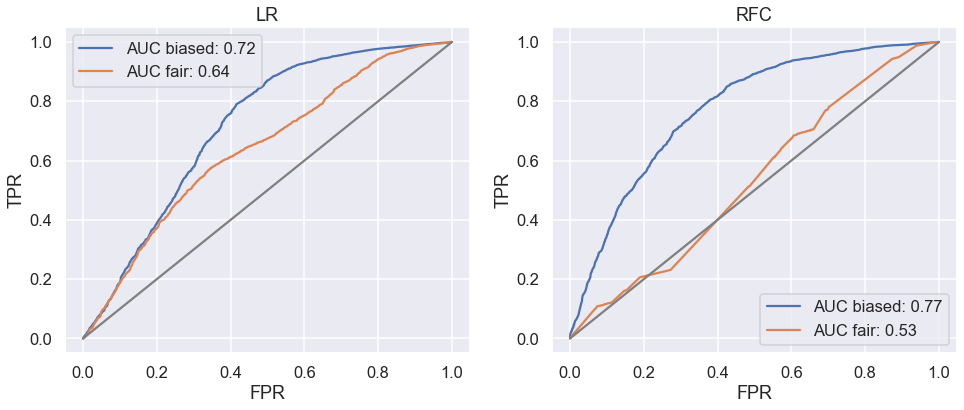

In [21]:
%matplotlib inline
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray], title: str='', ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, y=tpr, ci=None, ax=ax)
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray',ax=ax)
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [BiasedLogModel.score(X_test, y_test), 
                                 UnbiasedLogModel.score(X_lfr_test, y_lfr_test)],
                      'RFC': [BiasedRfcModel.score(X_test, y_test),
                              UnbiasedRfcModel.score(X_lfr_test, y_lfr_test)]}, 
                      index =['Biased', 'Fair']))

print('AUC:')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
plot_auc(y_test, 
         {'AUC biased': BiasedLogModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedLogModel.predict_proba(X_lfr_test)[:, 1]},
         title='LR', ax=ax[0]) 
plot_auc(y_test, 
         {'AUC biased': BiasedRfcModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedRfcModel.predict_proba(X_lfr_test)[:, 1]},
         title='RFC', ax=ax[1]) 
plt.show()

In [22]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier], names: List[str],scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names, 'importance': imp,
                         'std': var}).sort_values('importance', ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

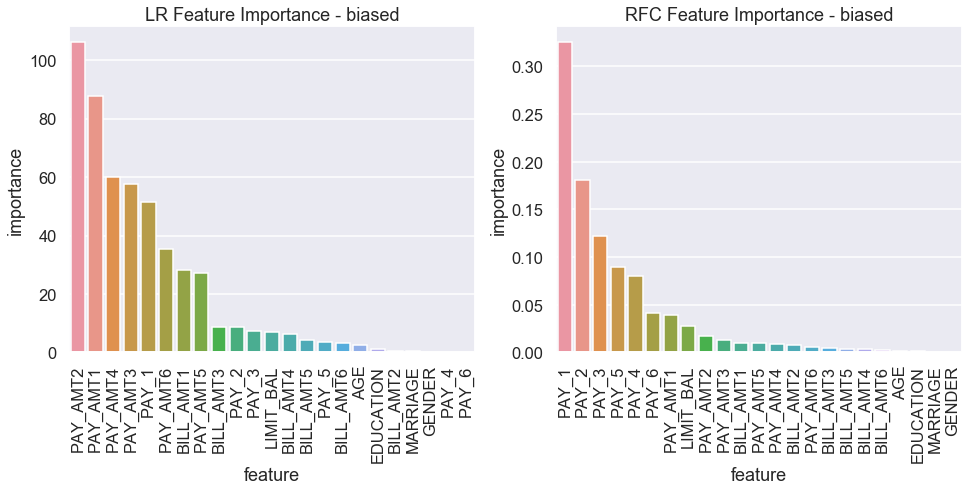

In [23]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedLogModel, names=X_train.columns.tolist(),
                                                scale=X_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - biased')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedRfcModel, names=X_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - biased')

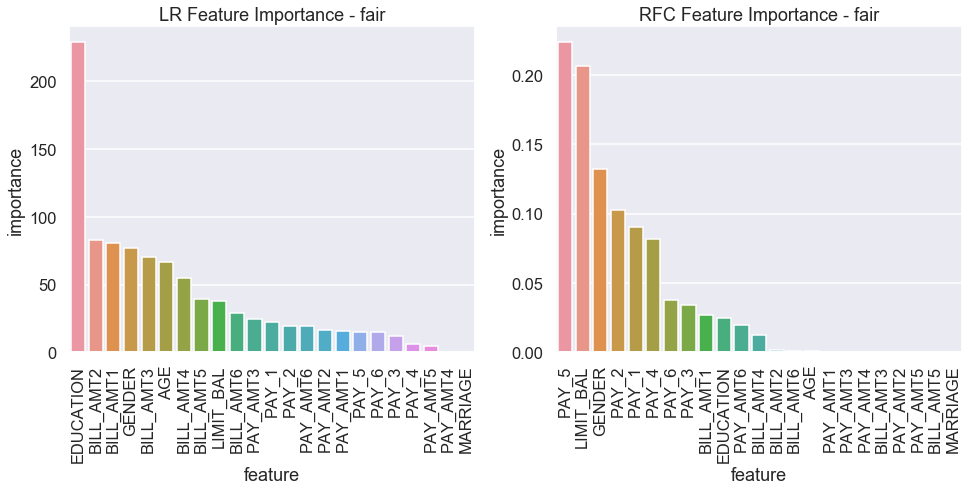

In [24]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedLogModel, names=X_lfr_train.columns.tolist(), 
                                                scale=X_lfr_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - fair')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedRfcModel, names=X_lfr_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - fair')

In [25]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true), axis=1),label_names=[lab],
                                  protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label, unfavorable_label=unfav_label)

    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy          = []
    balanced_accuracy = []
    disp_impact       = []
    average_abs_odds_difference = []
    avg_odd_diff = []
    equal_opportunity_difference = []
    error_rate = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
#        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        disp_impact.append(np.abs(valid_metric.disparate_impact()))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate},
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

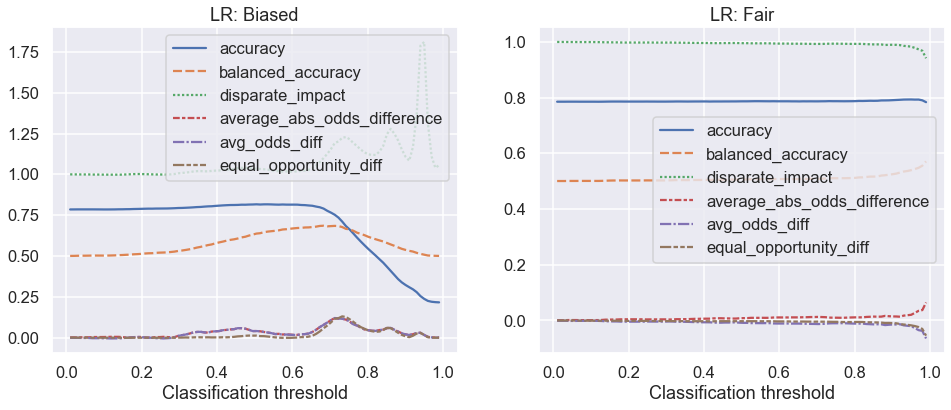

In [26]:
# Plot for Logistic Regression Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
with warnings.catch_warnings():
     warnings.simplefilter('ignore', RuntimeWarning)
    
     plot_metrics(calc_metrics(BiasedLogModel, X_test, y_test), ax=ax[0], title="LR: Biased")
 
     plot_metrics(calc_metrics(UnbiasedLogModel, X_lfr_test, y_lfr_test), ax=ax[1], title="LR: Fair")

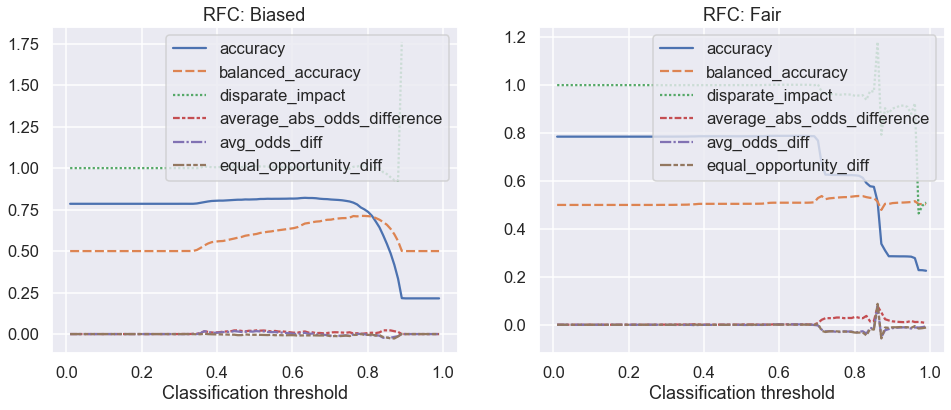

In [27]:
# Plot for Random Forest Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(BiasedRfcModel, X_test, y_test), ax=ax[0], title="RFC: Biased")
    
    plot_metrics(calc_metrics(UnbiasedRfcModel, X_lfr_test, y_lfr_test), ax=ax[1], title="RFC: Fair")

In [28]:
display(Markdown("#### Individual fairness metrics"))
print("Consistency of labels in transformed training dataset= %f" %metric_train_lfr.consistency())
print("Consistency of labels in original training dataset= %f" %metric_train_bld.consistency())

#### Individual fairness metrics

Consistency of labels in transformed training dataset= 0.999518
Consistency of labels in original training dataset= 0.781973


In [29]:
# Check whether the transform on the original dataset has worked. 
# A false means that the dataset is transformed.
Taiwan_train_lfr_df.equals(Taiwan_train_df)

False

In [30]:
Taiwan_train_df     = Taiwan_train_df.reset_index(drop=True)
Taiwan_train_lfr_df = Taiwan_train_lfr_df.reset_index(drop=True)
TaiwanBool          = (Taiwan_train_df != Taiwan_train_lfr_df).stack()  # Create Frame of comparison booleans
Taiwandiff          = pd.concat([Taiwan_train_df.stack()[TaiwanBool], Taiwan_train_lfr_df.stack()[TaiwanBool]], axis=1)
Taiwandiff.columns  =["Taiwan_train_df", "Taiwan_train_lfr"]
print(Taiwandiff)

                 Taiwan_train_df  Taiwan_train_lfr
0     LIMIT_BAL         0.313131          0.266470
      GENDER            1.000000          0.758627
      EDUCATION         0.333333          0.430842
      AGE               0.185185          0.227513
      PAY_1             0.000000         -0.662157
      PAY_2             0.000000         -0.296935
      PAY_3             0.000000         -0.105138
      PAY_4             0.000000          0.084008
      PAY_5             0.000000          0.035973
      PAY_6             0.000000         -0.063222
      BILL_AMT1         0.149718          0.270552
      BILL_AMT2         0.067747          0.058242
      BILL_AMT3         0.160686          0.248112
      BILL_AMT4         0.086829          0.280965
      BILL_AMT5         0.082278          0.106581
      BILL_AMT6         0.180211          0.157207
      PAY_AMT1          0.007341         -0.153158
      PAY_AMT2          0.004406         -0.313895
      PAY_AMT3          0.00352

In [31]:
## PCA Analysis of consitency

In [32]:
# At this stage the transformed dataframe will have the last threshold encountered!
feat_cols = Taiwan_train_bld.feature_names

orig_df = pd.DataFrame(Taiwan_train_bld.features,columns=feat_cols)
orig_df['label'] = Taiwan_train_bld.labels
orig_df['label'] = orig_df['label'].apply(lambda i: str(i))

transf_df = pd.DataFrame(Taiwan_train_lfr.features,columns=feat_cols)
transf_df['label'] = Taiwan_train_lfr.labels
transf_df['label'] = transf_df['label'].apply(lambda i: str(i))

In [33]:
from sklearn.decomposition import PCA

orig_pca = PCA(n_components=3)
orig_pca_result = orig_pca.fit_transform(orig_df[feat_cols].values)

orig_df['pca-one'] = orig_pca_result[:,0]
orig_df['pca-two'] = orig_pca_result[:,1] 
orig_df['pca-three'] = orig_pca_result[:,2]

display(Markdown("#### Original training dataset"))
print('Explained variation per principal component:')
print(orig_pca.explained_variance_ratio_)

#### Original training dataset

Explained variation per principal component:
[0.36648267 0.33357623 0.10422612]


In [34]:
transf_pca = PCA(n_components=3)
transf_pca_result = transf_pca.fit_transform(transf_df[feat_cols].values)

transf_df['pca-one'] = transf_pca_result[:,0]
transf_df['pca-two'] = transf_pca_result[:,1] 
transf_df['pca-three'] = transf_pca_result[:,2]

display(Markdown("#### Transformed training dataset"))
print('Explained variation per principal component:')
print(transf_pca.explained_variance_ratio_)

#### Transformed training dataset

Explained variation per principal component:
[9.85015832e-01 1.46296596e-02 2.98040144e-04]


In [35]:
###Load, clean up original test data and compute metric

In [36]:
display(Markdown("#### Testing Dataset shape"))
print(Taiwan_test_bld.features.shape)

metric_test_bld = BinaryLabelDatasetMetric(Taiwan_test_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_test_bld.mean_difference())

#### Testing Dataset shape

(8887, 23)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.023257


In [37]:
###Transform test data and compute metric

In [38]:
Taiwan_test_lfr = TR.transform(Taiwan_test_bld, threshold=threshold)
metric_test_lfr = BinaryLabelDatasetMetric(Taiwan_test_lfr, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

In [39]:
print("Consistency of labels in tranformed test dataset= %f" %metric_test_lfr.consistency())

Consistency of labels in tranformed test dataset= 0.999280


In [40]:
print("Consistency of labels in original test dataset= %f" %metric_test_bld.consistency())

Consistency of labels in original test dataset= 0.791156


In [41]:
def check_algorithm_success():
#   """Transformed dataset consistency should be greater than original dataset."""
    assert metric_test_lfr.consistency() > metric_test_bld.consistency(), "Transformed dataset consistency should be greater than original dataset."
print(check_algorithm_success())

None


In [42]:
# Is it possible to predict the Sensitive Variable from the transformed dataset
X_se_train = Taiwan_train_lfr_df.drop(protected_attr,axis=1)
y_se_train = Taiwan_train_lfr_df[protected_attr]
X_se_test  = Taiwan_test_df.drop(protected_attr,axis=1)
y_se_test  = Taiwan_test_df[protected_attr]

Se_UnbiasedLogModel = LogisticRegression(random_state=101)
Se_UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_UnbiasedLogModel.fit(X_se_train, y_se_train) 
Se_UnbiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_UnbiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_UnbiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_UnbiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_UnbiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.48115224485203106
Biased Random Forest       validation accuracy: 0.5084955553055024

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.5064166470033035
Biased Random Forest       balanced accuracy  : 0.5282563038030301


In [43]:
# Lastly get the number of labels from the modified training dataset
print('Training After - DEFAULT value counts:')
print(Taiwan_train_lfr_df.DEFAULT.value_counts())
print('Training After - MARRIAGE value counts:')
print(Taiwan_train_lfr_df.MARRIAGE.value_counts())

Training After - DEFAULT value counts:
1.0    20114
0.0      622
Name: DEFAULT, dtype: int64
Training After - MARRIAGE value counts:
0.0    11237
1.0     9499
Name: MARRIAGE, dtype: int64
